In [1]:
import sys
sys.path.insert(0, './py_torch_trpo')
from agent_file import agent
import gym
import scipy.optimize
import roboschool
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from baselines.common import set_global_seeds, tf_util as U
from baselines import bench
import gym, logging
import roboschool
from baselines import logger
from baselines.ppo1 import mlp_policy, pposgd_simple
from base_line_model.mlp import MlpPolicy_new
from base_line_model.PPO_agent import learning_agent
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

In [2]:
env = gym.make("RoboschoolWalker2d-v1")
env.seed(0)
np.random.seed(0)
seed = 1
logger.configure()
U.make_session(num_cpu=16).__enter__()
set_global_seeds(seed)

[2018-04-14 22:03:56,353] Making new env: RoboschoolWalker2d-v1


Logging to /tmp/openai-2018-04-14-22-03-56-371271


In [3]:
env2 = gym.make('RoboschoolWalker2d-v1')
env2 = bench.Monitor(env2, logger.get_dir(),allow_early_resets=True)
env2.seed(seed)
gym.logger.setLevel(logging.WARN)
class pargm(object):
    def __init__(self):
        self.timesteps_per_actorbatch = 25000#25000 # timesteps per actor per update
        self.clip_param = 0.2 
        self.entcoeff = 0.0 # clipping parameter epsilon, entropy coeff
        self.optim_epochs = 10 
        self.optim_stepsize = 3e-4
        self.optim_batchsize = 64# optimization hypers
        self.gamma = 0.99
        self.lam = 0.95 # advantage estimation
        self.max_timesteps=10e8#1e10 
        self.max_episodes=0 
        self.max_iters=0 
        self.max_seconds=0  # time constraint
        self.callback=None # you can do anything in the callback, since it takes locals(), globals()
        self.adam_epsilon=1e-5
        self.schedule='linear' # annealing for stepsize parameters (epsilon and adam)


def policy_fn(name, ob_space, ac_space):
        return MlpPolicy_new(name=name, ob_space=ob_space, ac_space=ac_space,
            hid_size=64, num_hid_layers=2)
    
parg = pargm()
agent2 = learning_agent('pi2', env2, policy_fn, parg)
agent2.restore('walker_mem')

[2018-04-14 22:03:56,428] Making new env: RoboschoolWalker2d-v1


INFO:tensorflow:Restoring parameters from walker_mem/data


[2018-04-14 22:03:57,971] Restoring parameters from walker_mem/data


In [4]:
class action_space(object):
    def __init__(self, env):
        self.env = env
        self.high = np.array([ 1,  1,  1,  1,  1])
        self.low = -np.array([ 1,  1,  1,  1,  1])
        self.shape = env.observation_space.shape
    
    def sample(self):
    
        return self.env.observation_space.sample()
        
        
class adversial_env(object):
    def __init__(self,ag):
        # parameter
        self.env = gym.make("RoboschoolWalker2d-v1")
        self.env.seed(0)
        self.ratio = 0.25 # change to 0.1 later in this script
        self.threshold = np.array([ 0.058152  ,  0.        ,  0.        ,  1.01691496,  0.        ,
        1.0058738 ,  0.        ,  0.12371043,  0.36834612,  0.48457339,
        0.44639227,  0.48621628,  0.13706243,  0.18893708,  0.34056485,
        0.46375769,  0.21651404,  0.23712605,  0.15025884,  0.14366789,
        0.48975313,  0.38099667])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = ag
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])+0.2*np.abs(st[1])-0.08
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        
        ac = self.agent.action_ev(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
            
        
        final_r = -r
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        x = list(range(0, len(self.score_list[1:])))
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.scatter(x,self.score_list[1:], s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('cumulative reward',fontsize=fon_size)
        plt.ylim([-3000,0])
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[1:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        x = list(range(0, len(self.epi_list)))
        plt.scatter(x,self.epi_list, s=5)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('time steps',fontsize=fon_size)
        plt.ylim([0,1200])
        plt.show()

# Define an adversarial

In [5]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 25000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = -150
        
args = par()
env = adversial_env(agent2)
agn = agent(env, args)
#agn.load_model('adv_agent_model/adversarial_agent2_distr')

# Agent training

In [6]:
agn.learn()

-2004.994318717443 [-2004.994318717443] [1000]
Episode 0	Last reward: -2031.6919915229337	Average reward -2015.85
('lagrange multiplier:', 0.6255808981196717, 'grad_norm:', 0.07679570577855921)
fval before -1.1606715588641236e-14
a/e/r 0.012871098757141071 0.012511617962392946 1.028731759220002
fval after -0.012871098757152678
Episode 1	Last reward: -1996.4967501795447	Average reward -1745.18
('lagrange multiplier:', 0.6434311408544717, 'grad_norm:', 0.08510449622191106)
fval before -1.1543754937084207e-16
a/e/r 0.013603974934313 0.012868622817090643 1.0571430313619687
fval after -0.013603974934313116
Episode 2	Last reward: -2021.4799277999334	Average reward -1978.77
('lagrange multiplier:', 0.6222385231625348, 'grad_norm:', 0.07959270672120587)
fval before 2.1983269302406034e-16
a/e/r 0.012860672786239325 0.012444770463250862 1.0334198468518656
fval after -0.012860672786239105
Episode 3	Last reward: -2028.059287836573	Average reward -1913.62
('lagrange multiplier:', 0.5788223560197803

In [7]:
env.ratio = 0.1
args.max_avg = -235

In [8]:
env.ratio

0.1

In [9]:
args.max_avg

-235

In [10]:
agn.learn()

Episode 0	Last reward: -2129.473461321419	Average reward -1950.62
('lagrange multiplier:', 0.6426660011307422, 'grad_norm:', 0.09663269441410947)
fval before 7.272394423029246e-15
a/e/r 0.013103211138415973 0.012853320022614979 1.0194417563214266
fval after -0.013103211138408701
Episode 1	Last reward: -2125.6222204136216	Average reward -1770.68
('lagrange multiplier:', 0.6203647968807653, 'grad_norm:', 0.09796835129860686)
fval before 1.8510858612044292e-17
a/e/r 0.012795377714832232 0.01240729593761618 1.0312785138008576
fval after -0.012795377714832213
Episode 2	Last reward: -2086.2196641163855	Average reward -1796.26
('lagrange multiplier:', 0.7195674276511134, 'grad_norm:', 0.12370380327027519)
fval before 1.2646938215931006e-16
a/e/r 0.014749826950425537 0.014391348553035171 1.0249092985323298
fval after -0.01474982695042541
Episode 3	Last reward: -2242.5037162299914	Average reward -1455.77
('lagrange multiplier:', 0.7129842927179932, 'grad_norm:', 0.11999336640734563)
fval before

In [11]:
env.ratio = 0.08
args.max_avg = -235

In [12]:
env.ratio

0.08

In [13]:
args.max_avg

-235

In [14]:
agn.learn()

Episode 0	Last reward: -330.0510514004344	Average reward -318.44
('lagrange multiplier:', 0.8958056175511411, 'grad_norm:', 0.21472786268071994)
fval before 1.974073778489529e-15
a/e/r 0.018294812340841005 0.01791611235109796 1.021137397573857
fval after -0.01829481234083903
Episode 1	Last reward: -312.228822191972	Average reward -301.30
('lagrange multiplier:', 0.8498744993099081, 'grad_norm:', 0.16625163704669704)
fval before -4.01552397151581e-17
a/e/r 0.016930670449660356 0.01699748998618905 0.996068858603065
fval after -0.016930670449660398
Episode 2	Last reward: -204.49735384031968	Average reward -270.73
('lagrange multiplier:', 0.8047841904770953, 'grad_norm:', 0.1457296742511767)
fval before -1.224392629672956e-15
a/e/r 0.01617996131770975 0.016095683809539046 1.0052360315453486
fval after -0.016179961317710975
Episode 3	Last reward: -326.7491776155407	Average reward -255.66
('lagrange multiplier:', 0.8468341588267365, 'grad_norm:', 0.17790911385773683)
fval before 7.6056976319

In [15]:
env.ratio = 0.05
args.max_avg = -250

In [16]:
env.ratio

0.05

In [17]:
args.max_avg

-250

In [18]:
agn.learn()

Episode 0	Last reward: -2092.654402914977	Average reward -1602.83
('lagrange multiplier:', 0.7146380664309084, 'grad_norm:', 0.13652245899878815)
fval before -4.2067806933776704e-15
a/e/r 0.014731989973110557 0.01429276132891749 1.030730845781662
fval after -0.014731989973114763
Episode 1	Last reward: -1096.5654929161606	Average reward -1488.38
('lagrange multiplier:', 0.6732177700555819, 'grad_norm:', 0.12868781304438665)
fval before 3.8907226227595006e-16
a/e/r 0.013664711470437435 0.013464355401095663 1.014880479857615
fval after -0.013664711470437046
Episode 2	Last reward: -1405.8253139670808	Average reward -1326.15
('lagrange multiplier:', 0.7259262571243289, 'grad_norm:', 0.13737506093344434)
fval before -1.3895563565299307e-16
a/e/r 0.015059724101272279 0.014518525142491743 1.0372764418884803
fval after -0.015059724101272418
Episode 3	Last reward: -970.7397417986973	Average reward -1042.96
('lagrange multiplier:', 0.7088200993064885, 'grad_norm:', 0.14711710295581734)
fval befor

fval before -1.1947450067827407e-16
a/e/r 0.01675387152200908 0.016843147543866264 0.9946995642219083
fval after -0.016753871522009196
Episode 30	Last reward: -441.9000301910986	Average reward -279.69
('lagrange multiplier:', 0.8498766939439921, 'grad_norm:', 0.1755466792148408)
fval before -1.6727621620387192e-16
a/e/r 0.016952797189214504 0.01699753387887943 0.9973680482131285
fval after -0.01695279718921467
Episode 31	Last reward: -215.90429837231784	Average reward -268.82
('lagrange multiplier:', 0.7741476932386987, 'grad_norm:', 0.16229533824841583)
fval before 3.461970721043946e-16
a/e/r 0.015383557533792861 0.015482953864769415 0.9935802733868035
fval after -0.015383557533792514
Episode 32	Last reward: -194.50093763281913	Average reward -264.21
('lagrange multiplier:', 0.8228589410789401, 'grad_norm:', 0.17195950261514015)
fval before 2.4892299961318517e-16
a/e/r 0.016220564777157612 0.016457178821595555 0.9856224419140751
fval after -0.016220564777157363
Episode 33	Last reward:

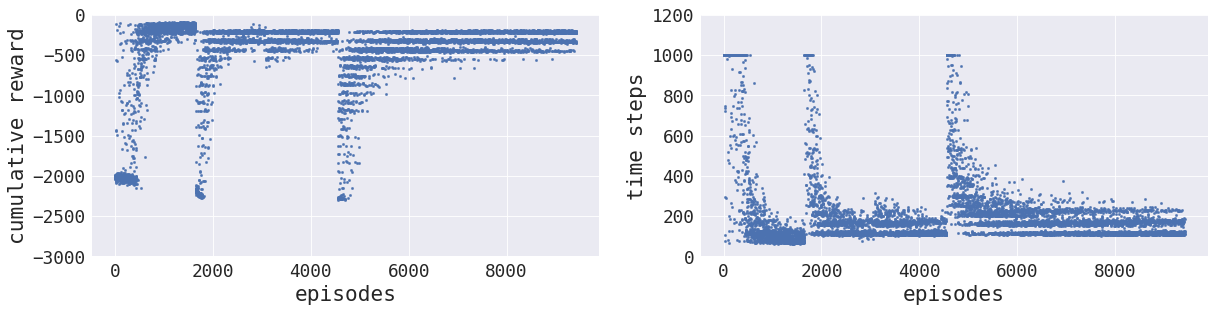

In [19]:
env.result_plot()

# Agent evaluation

In [20]:
env = adversial_env(agent2)
env.ratio = 0.05
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r
    print(score)

-220.34761249445725 [-220.34761249445725] [110]
-205.34761249445725
-211.49462840208443
-220.33741157943294
-207.3261805395566
-349.66043641911824
-202.2497519897239
-230.68297049411345
-197.8411911217903
-219.39719267299515
-214.28379843878204
-220.56852979348912
-225.58170272187564
-197.4889730252486
-219.917740595444
-222.11488310467385
-198.8025883063645
-209.1915754527261
-224.00910554581355
-211.1943334028809
-207.2222194228816
-210.57812802237896
-200.66631927844722
-194.16605866764147
-205.4556679186949
-198.53269224448735
-199.50056417606095
-331.04856901783626
-219.91056478034005
-216.1082941512709
-219.24468918815984
-223.12442489294477
-204.8264093450693
-204.23307899957572
-240.08388539586886
-195.20944983168587
-216.7645897945461
-232.84737839496086
-227.2961500432852
-192.27223571869257
-217.7136125191421
-218.04898766408581
-218.26143471406536
-214.75024393147905
-191.18995249098657
-227.31414550547342
-229.34123171433026
-212.79129215234423
-191.84502332183325
-201.378

-224.09569334645923
-337.95685670195843
-206.7189731107108
-196.56273186623434
-220.1310062029443
-207.90594785789878
-220.13114866896805
-215.7177994481113
-345.1717107938312
-196.97681398234133
-206.23483943163012
-207.7797884818793
-207.5417447598957
-236.58723489406842
-335.86417243542485
-198.06081574871354
-223.8373433755318
-200.47514492651248
-334.6676912676048
-213.4618580693423
-209.77908127399704
-211.65030567828939
-190.2414261860859
-234.9053390591129
-212.73702574556518
-207.73992103248463
-340.90480222175233
-333.09688307363837
-337.4737586084841
-192.74570914518557
-198.15648149614725
-212.51272768184134
-219.98395947152613
-200.87815392652263
-229.85672147734158
-216.04175951802605
-233.3539503663676
-238.96390726389652
-213.83464375360634
-192.87281689004732
-212.2318105481433
-229.6286518562207
-209.7676056608922
-200.9763329910973
-220.39837661267384
-232.4526490283155
-191.9140744892212
-198.08692146266696
-221.28874063327382
-356.004596372327
-225.29739202695347
-

-216.61968181698182
-232.28927838497475
-211.28192906533224
-208.63307834301088
-191.03098249078454
-210.93868290428955
-213.36441511303715
-348.36991845257893
-228.8379687828113
-207.2083572626638
-202.63502311168847
-211.65640899961866
-209.14170684363486
-215.40193380182754
-220.91406071889355
-344.2982833468545
-233.4343539349065
-210.92738435014473
-223.2957831207691
-197.95443834268238
-343.94778174585235
-337.722927070393
-329.0756615149398
-323.85608560431274
-226.94342659454284
-213.0121487548196
-234.04309071305033
-202.83627689820142
-340.9011402385875
-216.54342974240873
-208.29438947946767
-206.0743752985086
-220.8675823618863
-216.7836882932999
-208.82818884483865
-197.71604383673844
-205.83707294862117
-342.5367310672126
-197.92855054594543
-200.0634383998811
-199.82978058262674
-231.76813649869874
-215.07467172057378
-331.3742680210912
-225.4719514851022
-212.89897186175514
-202.16306327350327
-208.26992055251327
-230.52200909427773
-208.24182731004544
-222.444147861759

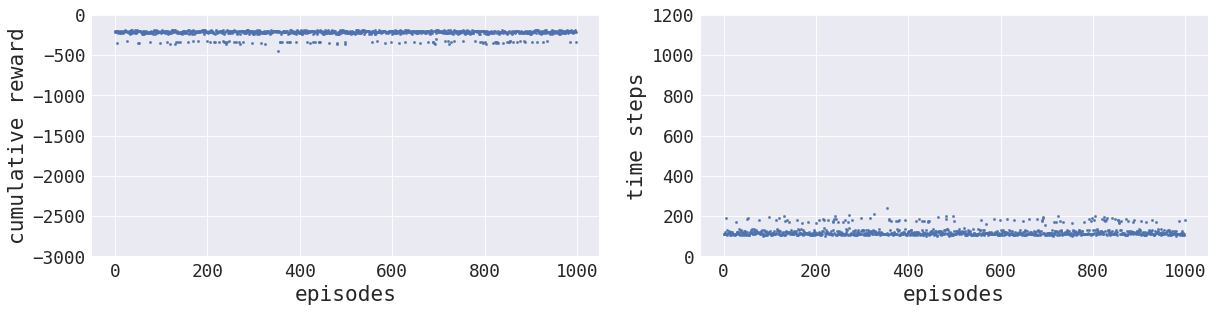

In [21]:
env.result_plot()

# Save model

In [22]:
agn.save_model('adv_agent_model/adversarial_agent2_distr')

# adversarial evaluation

In [23]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace", font_scale=2)

In [24]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 25000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 55
        
args = par()
env = adversial_env(agent2)
env.ratio = 0.01
agn = agent(env, args)
agn.load_model('adv_agent_model/adversarial_agent2_distr')

In [25]:
thres = np.array([ 0.058152  ,  0.        ,  0.        ,  1.01691496,  0.        ,
        1.0058738 ,  0.        ,  0.12371043,  0.36834612,  0.48457339,
        0.44639227,  0.48621628,  0.13706243,  0.18893708,  0.34056485,
        0.46375769,  0.21651404,  0.23712605,  0.15025884,  0.14366789,
        0.48975313,  0.38099667])

In [32]:
env = adversial_env(agent2)
env.ratio = 0.05
action = []
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        action.append(np.clip(a,-1,1)*thres*0.05)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

-222.12323217366932 [-222.12323217366932] [110]


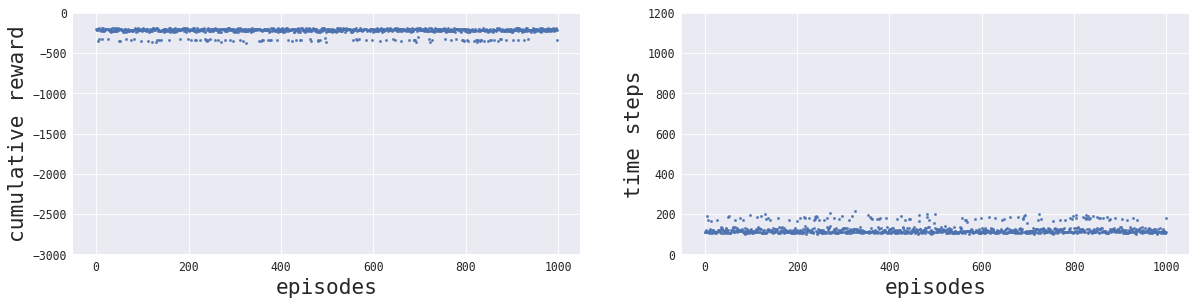

In [33]:
env.result_plot()

In [34]:
np.mean(env.score_list)

-226.25835719338741

In [35]:
np.array(action)

array([[ -1.44636735e-05,  -0.00000000e+00,  -0.00000000e+00, ...,
          1.46909916e-03,   3.15434363e-03,  -2.57400101e-03],
       [  7.59266810e-04,  -0.00000000e+00,  -0.00000000e+00, ...,
          1.55205437e-03,   7.75681398e-03,  -3.71579843e-03],
       [  1.08553567e-03,  -0.00000000e+00,   0.00000000e+00, ...,
          7.80318492e-04,   5.31391052e-03,  -6.24909598e-03],
       ..., 
       [  1.59693208e-03,   0.00000000e+00,   0.00000000e+00, ...,
          4.05892503e-03,   5.72551834e-03,   2.13287337e-03],
       [  1.13084891e-03,   0.00000000e+00,   0.00000000e+00, ...,
          4.00862548e-03,   3.86360790e-03,   5.28112374e-03],
       [  1.21017777e-03,   0.00000000e+00,   0.00000000e+00, ...,
          3.43370147e-03,   3.01099722e-03,   6.64500022e-03]])

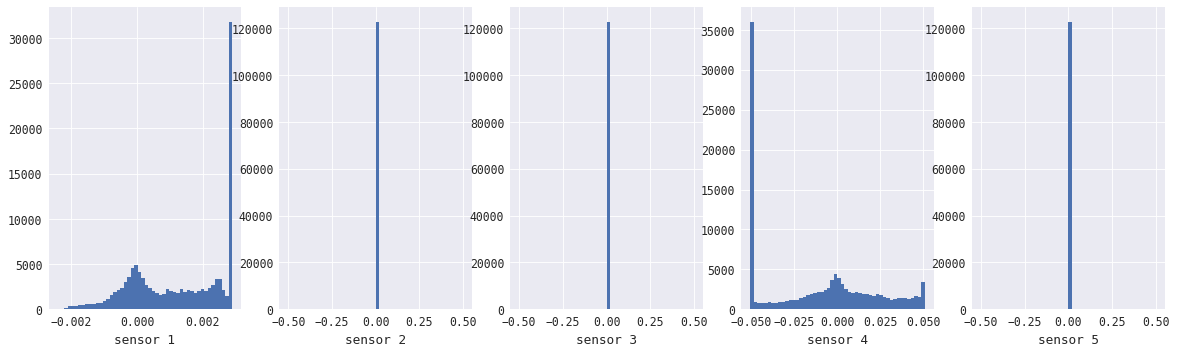

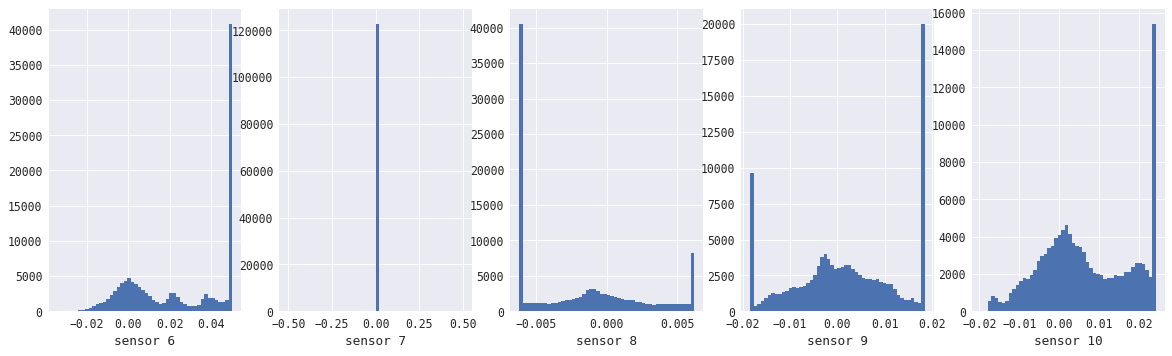

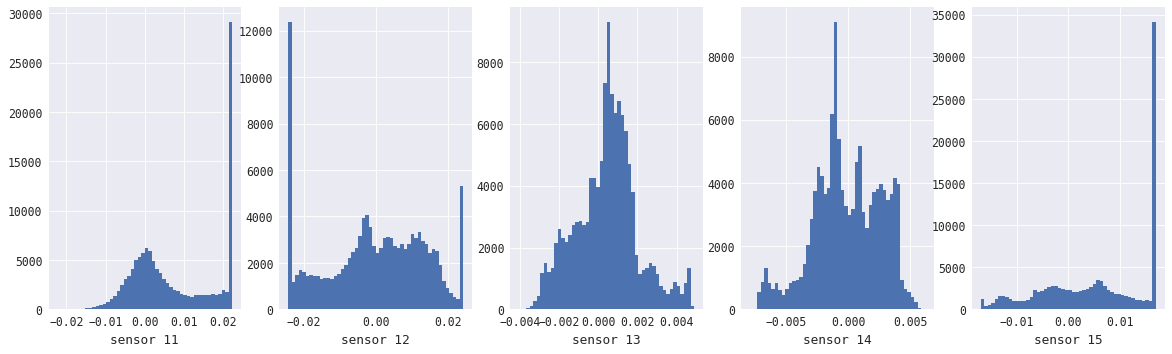

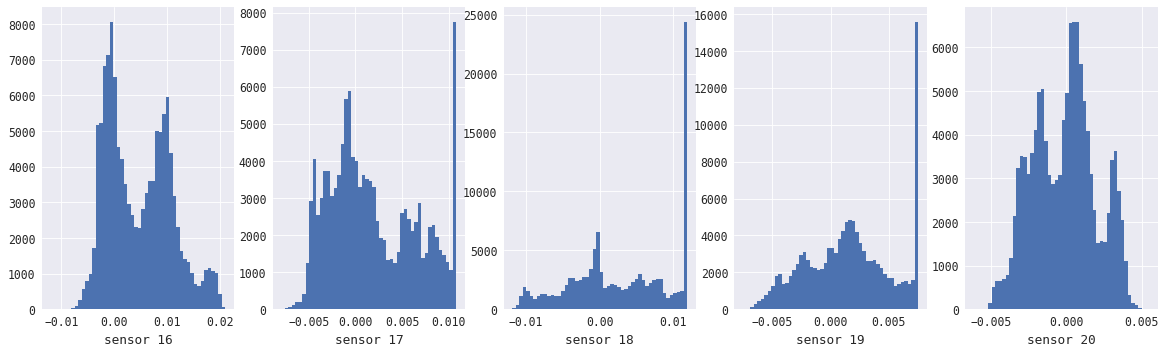

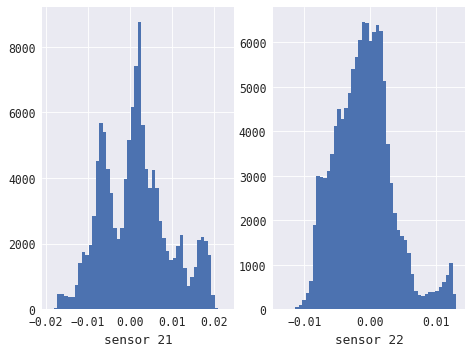

In [36]:
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,0], bins = bin_num)
plt.xlabel('sensor 1')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,1], bins = bin_num)
plt.xlabel('sensor 2')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,2], bins = bin_num)
plt.xlabel('sensor 3')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,3], bins = bin_num)
plt.xlabel('sensor 4')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,4], bins = bin_num)
plt.xlabel('sensor 5')

plt.show()


bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,5], bins = bin_num)
plt.xlabel('sensor 6')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,6], bins = bin_num)
plt.xlabel('sensor 7')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,7], bins = bin_num)
plt.xlabel('sensor 8')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,8], bins = bin_num)
plt.xlabel('sensor 9')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,9], bins = bin_num)
plt.xlabel('sensor 10')

plt.show()
bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,10], bins = bin_num)
plt.xlabel('sensor 11')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,11], bins = bin_num)
plt.xlabel('sensor 12')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,12], bins = bin_num)
plt.xlabel('sensor 13')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,13], bins = bin_num)
plt.xlabel('sensor 14')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,14], bins = bin_num)
plt.xlabel('sensor 15')

plt.show()

bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,15], bins = bin_num)
plt.xlabel('sensor 16')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,16], bins = bin_num)
plt.xlabel('sensor 17')

plt.subplot(1,5,3)
plt.hist(sensor_array[:,17], bins = bin_num)
plt.xlabel('sensor 18')

plt.subplot(1,5,4)
plt.hist(sensor_array[:,18], bins = bin_num)
plt.xlabel('sensor 19')

plt.subplot(1,5,5)
plt.hist(sensor_array[:,19], bins = bin_num)
plt.xlabel('sensor 20')

plt.show()

bin_num = 50
sensor_array = np.array(action)
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=1.3)
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,5,1)
plt.hist(sensor_array[:,20], bins = bin_num)
plt.xlabel('sensor 21')

plt.subplot(1,5,2)
plt.hist(sensor_array[:,21], bins = bin_num)
plt.xlabel('sensor 22')

plt.show()